In [2]:
import torch
from PIL import Image
import numpy as np
import time
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import pathlib
from pathlib import Path

from typing import Literal, Sequence

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_targets

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

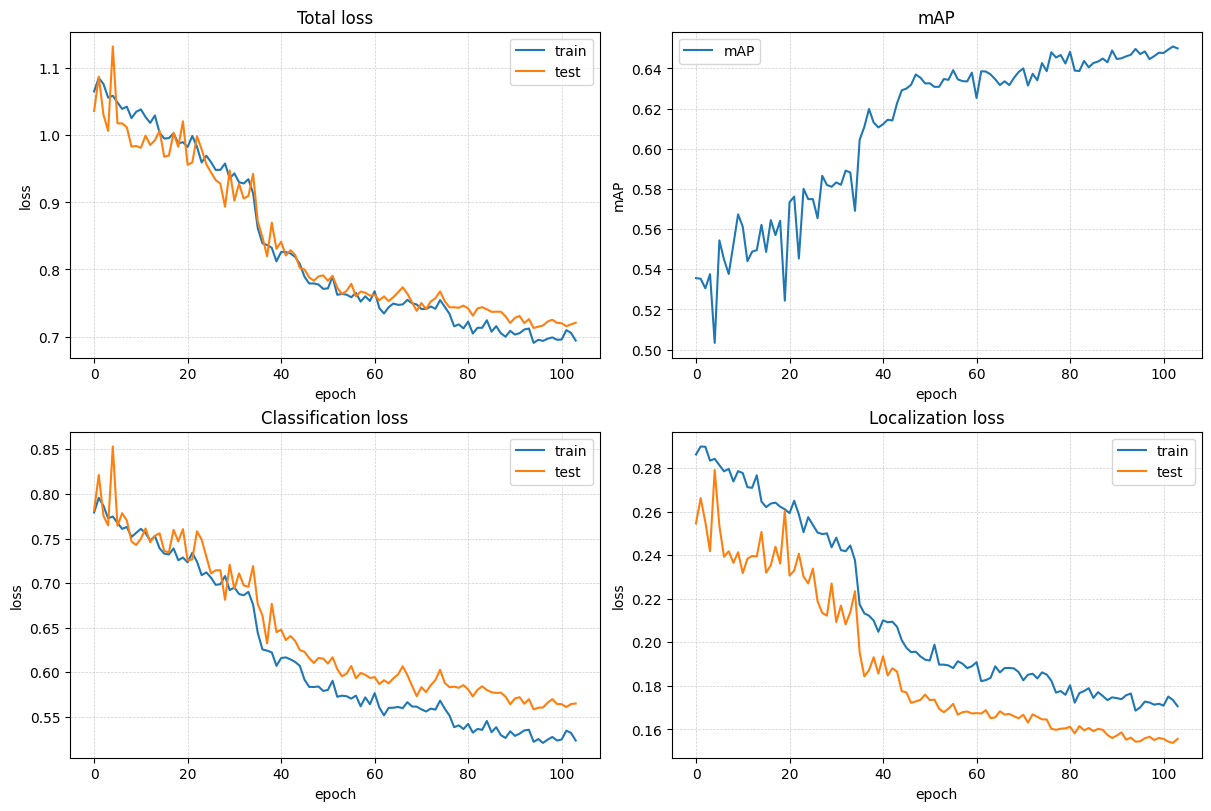

In [4]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map = 0, None


plot_losses(loss_dict, figsize=(12,8))

In [ ]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None


# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.2, rand_seed=724, device='cpu')
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, rand_state=724, transform_train=train_tfms, transform_test=test_tfms, device='cpu')


if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    priors_cxcywh=ssdtestmodel.priors,
                    device=device,
                    early_stopping_rounds=10,
                    epochs=25,
                    save_model=True,
                    epoch_save_interval=None,
                    SAVE_DIR=r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models",
                    timing=False,
                    past_train_dict=loss_dict
                    )

plot_losses(results)

  0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
print(scheduler.get_last_lr())

[9.375e-05]


In [ ]:
def max_fitting_batch_size(model, sample_batch, loss_fn, device, lo=1, hi=128):
    x, y = sample_batch  # one batch from your DataLoader with collate_detection
    x = x.to(device, non_blocking=True)
    # y is a dict/list of dicts; move tensors inside as needed
    def to_dev(t):
        return t.to(device, non_blocking=True) if hasattr(t, "to") else t
    y = [{k: to_dev(v) for k, v in t.items()} for t in y]

    import torch, math
    model.train()
    best = 0
    while lo <= hi:
        mid = (lo + hi) // 2
        try:
            torch.cuda.empty_cache()
            x_rep = x[:1].repeat(mid, 1, 1, 1)  # synthetic replicate
            y_rep = y * mid
            for p in model.parameters():
                if p.grad is not None: p.grad = None
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                out = model(x_rep)
                loss = loss_fn(out, y_rep)
            loss.backward()
            best = mid
            lo = mid + 1
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                hi = mid - 1
            else:
                raise
    return best


In [2]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=1e-3, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.02)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 8

ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.01, device='cpu')

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              persistent_workers=True,
                              prefetch_factor=1,
                              collate_fn=collate_detection
                              )

torch.cuda.synchronize()
t0 = time.time()
for batch, (images, targets) in enumerate(train_dataloader):
    torch.cuda.synchronize()
    t_load = time.time()
    images = images.to(device)
    
    # forward pass
    loc_all, conf_all = ssdtestmodel(images)
    N, P, C = conf_all.shape          # N - batch size, P - number of priors (8732), C - number of classes

    # -------- 1) Build per-image targets via encode() --------
    H, W = images.shape[-2], images.shape[-1]     # image size - should be 300x300
    norm = torch.tensor([W, H, W, H], device=device, dtype=torch.float32)

    loc_t_list   = []
    cls_t_list   = []
    pos_mask_lst = []

    for i in range(N):
        # normalize GT to [0,1] and convert to cxcywh
        gt_xyxy_px = targets[i]['boxes'].to(device=device, dtype=torch.float32)
        gt_labels  = targets[i]['labels'].to(device=device)
        if gt_xyxy_px.numel() == 0:
            gt_cxcywh = gt_xyxy_px.new_zeros((0,4))
        else:
            gt_xyxy = gt_xyxy_px / norm
            gt_cxcywh = box_convert(gt_xyxy, in_fmt='xyxy', out_fmt='cxcywh')

        loc_t, cls_t, pos_mask, _ = mySSD.encode_ssd(
            gt_cxcywh, gt_labels, ssdtestmodel.priors,
            iou_thresh=0.5, variances=(0.1, 0.2), background_class=0
        )
        # shapes: [P,4], [P], [P]
        loc_t_list.append(loc_t)
        cls_t_list.append(cls_t)
        pos_mask_lst.append(pos_mask)

    loc_t   = torch.stack(loc_t_list, dim=0).to(device)      # [N,P,4]
    cls_t   = torch.stack(cls_t_list, dim=0).to(device)      # [N,P]
    pos_mask = torch.stack(pos_mask_lst, dim=0).to(device)   # [N,P] bool
    neg_mask = ~pos_mask

    # number of positives per image (avoid zero division)
    num_pos_per_img = pos_mask.sum(dim=1)                    # [N]
    total_pos = num_pos_per_img.sum().clamp_min(1).float()   # scalar


    # -------- 2) Localization loss (positives only) --------
    # SmoothL1 on offsets (no decode), sum then normalize by #pos
    loc_loss_sL1 = torch.nn.functional.smooth_l1_loss(
        loc_all[pos_mask], loc_t[pos_mask], reduction='sum'
    ) / total_pos

    # -------- 3) Classification loss with hard-negative mining --------
    # cross-entropy per prior (no reduction)
    ce = torch.nn.functional.cross_entropy(
        conf_all.view(-1, C), cls_t.view(-1), reduction='none'
    ).view(N, P)  # [N,P]

    # keep CE on positives always
    ce_pos = (ce * pos_mask.float()).sum()

    # select hardest negatives per image at ratio R:1 w.r.t positives
    ce_neg_sum = torch.tensor(0.0, device=device)
    for i in range(N):
        n_pos = int(num_pos_per_img[i].item())
        if n_pos == 0:
            # still allow some negatives to contribute (common trick: pretend 1 positive)
            max_negs = int(3)
        else:
            max_negs = int(3 * n_pos)

        ce_neg_i = ce[i].masked_select(neg_mask[i])         # [#neg_i]
        if ce_neg_i.numel() == 0 or max_negs == 0:
            continue
        k = min(max_negs, ce_neg_i.numel())
        topk_vals, _ = torch.topk(ce_neg_i, k, largest=True, sorted=False)
        ce_neg_sum += topk_vals.sum()

    conf_loss = (ce_pos + ce_neg_sum) / total_pos

    # loss
    batch_loss = loc_loss_sL1 + conf_loss
    
    # loc_loss += loc_loss_sL1.item()
    # cls_loss += conf_loss.item()
    # train_loss += batch_loss.item()

    # Optimizer zero grad
    optimizer.zero_grad(set_to_none=True)

    # loss backward
    batch_loss.backward()

    # optimizer step
    optimizer.step()


    t_step = time.time()
    if batch<15:
        print(f"batch {batch}: load {t_load-t0:.3f}s, step {t_step-t_load:.3f}s")
        t0 = time.time()
    else:
        break

batch 0: load 54.642s, step 2.101s
batch 1: load 0.000s, step 0.498s
batch 2: load 0.001s, step 0.304s
batch 3: load 0.224s, step 0.340s
batch 4: load 0.226s, step 0.438s
batch 5: load 0.219s, step 0.396s
batch 6: load 0.218s, step 0.266s
batch 7: load 0.220s, step 0.276s
batch 8: load 0.221s, step 0.303s
batch 9: load 0.223s, step 0.337s
batch 10: load 0.214s, step 0.320s
batch 11: load 0.219s, step 0.270s
batch 12: load 0.220s, step 0.259s


In [15]:
BATCH_SIZE = 8
NUM_WORKERS = 8

ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.01, device='cpu')

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              persistent_workers=True,
                              prefetch_factor=1,
                              collate_fn=collate_detection
                              )

torch.cuda.synchronize()
t0 = time.time()

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

# turn on inference mode
with torch.inference_mode():

    for batch, (images, targets) in enumerate(train_dataloader):
        torch.cuda.synchronize()
        t_load = time.time()
        images = images.to(device, non_blocking=True)
        for i in range(len(targets)):
            for key in targets[i]:
                targets[i][key] = targets[i][key].to(device=device, non_blocking=True)

        loc_all, conf_all = ssdtestmodel(images)
        N, P, C = conf_all.shape          # N - batch size, P - number of priors (8732), C - number of classes
        H, W = images.shape[-2], images.shape[-1]
        norm = torch.tensor([W, H, W, H], device=device, dtype=torch.float32)

        # ---------- Build targets (same as train) ----------
        pos_mask, loc_t_pm, cls_t = build_targets(priors_cxcywh=ssdtestmodel.priors,
                                                targets=targets,
                                                H=images.shape[-2],
                                                W=images.shape[-1],
                                                iou_thresh=0.5,
                                                variances=(0.1, 0.2),
                                                device=device)
    
        # number of positives per image (avoid zero division)
        num_pos_per_img = pos_mask.sum(dim=1)                    # [N]
        total_pos = num_pos_per_img.sum().clamp_min(1).float()   # scalar

        # ---------- Losses (no backward) ----------
        # Localization: SmoothL1 on positives only
        batch_loc_loss = torch.nn.functional.smooth_l1_loss(loc_all[pos_mask], loc_t_pm, reduction="sum") / total_pos

        # Classification: cross-entropy with hard-negative mining (same as train)
        ce = torch.nn.functional.cross_entropy(conf_all.view(-1, C), cls_t.view(-1), reduction="none").view(N, P)
        ce_pos = (ce * pos_mask.float()).sum()

        ce_neg_sum = torch.tensor(0.0, device=device)
        for i in range(N):
            n_pos = int(num_pos_per_img[i].item())
            max_negs = int(3 * n_pos) if n_pos > 0 else int(3)
            ce_neg_i = ce[i].masked_select(~pos_mask[i])   # [#neg_i]
            if ce_neg_i.numel() > 0 and max_negs > 0:
                k = min(max_negs, ce_neg_i.numel())
                ce_neg_sum += ce_neg_i.topk(k, largest=True).values.sum()

        batch_conf_loss = (ce_pos + ce_neg_sum) / total_pos
        batch_total_loss = batch_loc_loss + batch_conf_loss

        # loc_loss += batch_loc_loss.item()
        # conf_loss += batch_conf_loss.item()
        # test_loss += batch_total_loss.item()

        t0_pred = time.perf_counter()
        preds = ssdtestmodel.predict(images, score_thresh=0.2, max_per_img=100)
        t1_pred = time.perf_counter()
        print(f"prediction time: {t1_pred - t0_pred:.3f}")


        map_metric.update(preds=preds, target=targets)
        # batch_count += 1





        


        t_step = time.time()
        if batch<15:
            print(f"batch {batch}: load {t_load-t0:.3f}s, step {t_step-t_load:.3f}s")
            t0 = time.time()
        else:
            break

t0_mAP = time.perf_counter()
mAP = map_metric.compute()
t1_mAP = time.perf_counter()
print(f"mAP time: {t1_mAP - t0_mAP:.3f}")

prediction time: 0.505
batch 0: load 50.254s, step 1.538s
prediction time: 0.330
batch 1: load 0.002s, step 0.850s
prediction time: 0.384
batch 2: load 0.000s, step 0.818s
prediction time: 0.312
batch 3: load 0.000s, step 0.733s
prediction time: 0.318
batch 4: load 0.000s, step 0.682s
prediction time: 0.295
batch 5: load 0.007s, step 0.737s
prediction time: 0.301
batch 6: load 0.000s, step 0.694s
prediction time: 0.308
batch 7: load 0.000s, step 0.722s
prediction time: 0.279
batch 8: load 0.000s, step 0.640s
prediction time: 0.315
batch 9: load 0.001s, step 0.725s
prediction time: 0.315
batch 10: load 0.004s, step 0.693s
prediction time: 0.330
batch 11: load 0.001s, step 0.777s
prediction time: 0.334
batch 12: load 0.005s, step 0.698s
prediction time: 0.282
batch 13: load 0.000s, step 0.642s
prediction time: 0.427
batch 14: load 0.001s, step 1.004s
prediction time: 0.329
mAP time: 0.256


In [5]:
def show_with_box(
    img_plus_target,
    color: str = "C0",
    lw: int = 2,
    label: bool = False,
    pred_box: bool = False,
    bbox_pred: torch.Tensor | np.ndarray | None = None,
    label_pred: Sequence[str] | None = None,
    lw_pred: int = 2,
    # NEW: describe what coordinate system predictions are in
    pred_ref: Literal["size", "normalized", "current"] = "size",
    pred_size: tuple[int, int] = (300, 300),  # (H_ref, W_ref) used when pred_ref == "size"
):
    """
    Plot GT boxes (in image pixel coords) and optional predicted boxes
    whose coords may be defined in a different reference frame.

    pred_ref:
      - "size": bbox_pred is in pixel coords of a reference frame with size pred_size=(H_ref, W_ref)
      - "normalized": bbox_pred is in [0,1] relative to the displayed image (H,W)
      - "current": bbox_pred already matches the displayed image pixel coords
    """

    # unpack
    img, target = img_plus_target

    # ----- convert the image to a numpy array (H,W,C, uint8) -----
    if isinstance(img, Image.Image):
        arr = np.array(img)
    elif isinstance(img, np.ndarray):
        arr = img
        if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
            arr = np.transpose(arr, (1, 2, 0))
    elif isinstance(img, torch.Tensor):
        t = img.detach().cpu()
        if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
            t = t.permute(1, 2, 0)
        arr = t.numpy()
    else:
        raise TypeError(f"Unsupported image type: {type(img)}")

    if arr.dtype.kind == "f" and arr.max() <= 1.0:
        arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
    elif arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)

    # ----- figure / axes -----
    H, W = arr.shape[:2]
    dpi = 100
    fig, ax = plt.subplots(figsize=(W / dpi, H / dpi), dpi=dpi)
    ax.imshow(arr)  # y downward

    # ----- helper: to numpy float32 (N,4) -----
    def _to_np_xyxy(x):
        if x is None:
            return None
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().float().numpy()
        else:
            x = np.asarray(x, dtype=np.float32)
        if x.ndim == 1:
            x = x[None, :]
        assert x.shape[1] == 4, f"Expected (...,4) boxes; got {x.shape}"
        return x

    # ----- draw GT boxes (assumed already in image pixel coords) -----
    gt_boxes = _to_np_xyxy(target["boxes"])
    gt_labels = target.get("labels", None)

    for i in range(gt_boxes.shape[0]):
        x_min, y_min, x_max, y_max = gt_boxes[i]
        # clip
        x_min, y_min = max(0.0, x_min), max(0.0, y_min)
        x_max, y_max = min(W - 1.0, x_max), min(H - 1.0, y_max)
        if not (x_max > x_min and y_max > y_min):
            continue

        rect = Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=lw,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        if label and gt_labels is not None:
            # your mapping; convert tensor→int safely
            label_dict = {'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4}
            lab_val = gt_labels[i].item() if isinstance(gt_labels[i], torch.Tensor) else int(gt_labels[i])
            # inverse lookup; raise if not found rather than silently wrong
            try:
                im_label = next(k for k, v in label_dict.items() if v == lab_val)
            except StopIteration:
                im_label = str(lab_val)
            ax.text(
                x_min,
                y_min,
                im_label,
                fontsize=10,
                color="white",
                va="bottom",
                ha="right",
                bbox=dict(facecolor=color, alpha=0.6, pad=2, edgecolor="none"),
            )

    # ----- predicted boxes: rescale to current image if needed -----
    if pred_box and bbox_pred is not None:
        pb = _to_np_xyxy(bbox_pred)

        if pred_ref == "current":
            # already in the displayed image pixel space
            pb_img = pb
        elif pred_ref == "normalized":
            # [0,1] relative to (W,H)
            sx, sy = float(W), float(H)
            pb_img = pb.copy()
            pb_img[:, [0, 2]] *= sx
            pb_img[:, [1, 3]] *= sy
        elif pred_ref == "size":
            Href, Wref = pred_size
            if Href <= 0 or Wref <= 0:
                raise ValueError(f"Invalid pred_size={pred_size}. Expect positive (H_ref, W_ref).")
            sx = float(W) / float(Wref)
            sy = float(H) / float(Href)
            pb_img = pb.copy()
            # scale x by sx, y by sy
            pb_img[:, [0, 2]] *= sx
            pb_img[:, [1, 3]] *= sy
        else:
            raise ValueError(f"Unsupported pred_ref={pred_ref}")

        # draw predictions (green)
        for i in range(pb_img.shape[0]):
            x_min, y_min, x_max, y_max = pb_img[i]
            x_min, y_min = max(0.0, x_min), max(0.0, y_min)
            x_max, y_max = min(W - 1.0, x_max), min(H - 1.0, y_max)
            if not (x_max > x_min and y_max > y_min):
                continue

            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=lw_pred,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

            if label_pred is not None:
                if i >= len(label_pred):
                    # mismatch; don't pretend otherwise
                    raise IndexError(f"label_pred length {len(label_pred)} < number of boxes {pb_img.shape[0]}")
                ax.text(
                    x_max,
                    y_max,
                    str(label_pred[i]),
                    fontsize=10,
                    color="white",
                    va="top",
                    ha="left",
                    bbox=dict(facecolor="g", alpha=0.6, pad=2, edgecolor="none"),
                )

    ax.axis("off")
    plt.close(fig)
    return fig

In [6]:
def ids_to_names(ids, mapping, unknown="UNK"):
    out = []
    for i in ids:
        if i in mapping:
            out.append(mapping[i])
        else:
            # choose: raise or use a sentinel
            # raise ValueError(f"Unknown class id {i}")
            out.append(unknown)
    return out


class_to_idx_dict = {'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4}

if len(set(class_to_idx_dict.values())) != len(class_to_idx_dict):
    raise ValueError("Duplicate ids in train_data.class_to_idx; cannot invert cleanly.")
id2name = {v: k for k, v in class_to_idx_dict.items()}

In [7]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=3e-3, momentum=0.9)
scheduler_loaded = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_loaded, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None

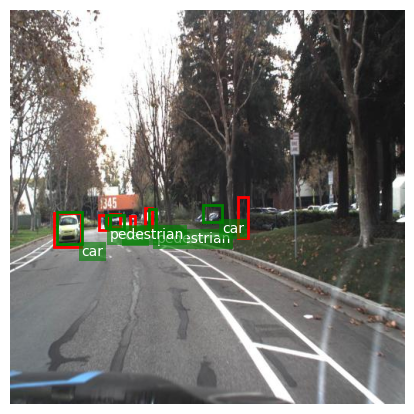

In [25]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data_clean = CarImageClass.ImageClass(targ_dir=test_path, transform=min_tfms, file_pct=1, device=device)
test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

idx = np.random.randint(0, len(test_data))

testpred = ssdtestmodel_loaded.predict(test_data[idx][0].unsqueeze(dim=0).to(device), score_thresh=0.2, max_per_img=200)

pred_boxs = testpred[0]['boxes'].to('cpu')
pred_labels = ids_to_names(testpred[0]['labels'].tolist() if type(testpred[0]['labels']) != list else testpred[0]['labels'], mapping=id2name)

total_preds = 5
# show_with_box(test_data_clean[idx], color='r', lw=2, label=False, pred_box=True, bbox_pred=pred_boxs[0:total_preds], label_pred=pred_labels[0:total_preds])
fig = show_with_box(
    test_data_clean[idx],
    color='r',
    lw=2,
    pred_box=True,
    bbox_pred=pred_boxs[0:total_preds],           # xyxy in 300×300 pixels
    label_pred=pred_labels[0:total_preds],
    lw_pred=2,
    pred_ref="size",
    pred_size=(300, 300)
)

fig

In [2]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=1e-3, momentum=0.9)
scheduler_loaded = StepLR(optimizer_loaded, step_size=5, gamma=0.8)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "best.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssdtestmodel_loaded.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

{'map': tensor(0.3613),
 'map_50': tensor(0.3613),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3002),
 'map_medium': tensor(0.5439),
 'map_large': tensor(0.9075),
 'mar_1': tensor(0.2151),
 'mar_10': tensor(0.4208),
 'mar_100': tensor(0.4215),
 'mar_small': tensor(0.3661),
 'mar_medium': tensor(0.6041),
 'mar_large': tensor(0.9192),
 'map_per_class': tensor([0.2077, 0.5691, 0.1289, 0.4254, 0.4754]),
 'mar_100_per_class': tensor([0.2585, 0.6276, 0.1954, 0.5067, 0.5194]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [ ]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=1e-3, momentum=0.9)
scheduler_loaded = StepLR(optimizer_loaded, step_size=5, gamma=0.8)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "L1Loss_no_mAP_11_7_2025.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device='cpu')

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                            #  num_workers=NUM_WORKERS,
                            #  persistent_workers=True,
                            #  prefetch_factor=1,
                            #  pin_memory=True,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

pred_time = 0
metric_update_time = 0
batch_counter = 0

for images, targets in test_dataloader:
    t0 = time.perf_counter()
    preds = ssdtestmodel_loaded.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    t1 = time.perf_counter()
    pred_time += t1 - t0
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)
    t2 = time.perf_counter()
    metric_update_time += t2 - t1

    batch_counter += 1

t3 = time.perf_counter()
results = map_metric.compute()
t4 = time.perf_counter()
print(f"Metric computation time: {t4 - t3:.6f} s")

print(f"Average prediction time: {pred_time/batch_counter:.6f}")

print(f"Average update time: {metric_update_time/batch_counter:.6f}")

print(results)

Metric computation time: 2.019606 s
Average prediction time: 0.185348
Average update time: 0.005478
{'map': tensor(0.1652), 'map_50': tensor(0.1652), 'map_75': tensor(-1.), 'map_small': tensor(0.0745), 'map_medium': tensor(0.5174), 'map_large': tensor(0.8546), 'mar_1': tensor(0.1157), 'mar_10': tensor(0.1950), 'mar_100': tensor(0.1952), 'mar_small': tensor(0.1059), 'mar_medium': tensor(0.5669), 'mar_large': tensor(0.8679), 'map_per_class': tensor([0.0390, 0.3182, 0.0484, 0.1359, 0.2847]), 'mar_100_per_class': tensor([0.0505, 0.3643, 0.0773, 0.1665, 0.3173]), 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}


In [6]:
results['map_50']

tensor(0.1652)

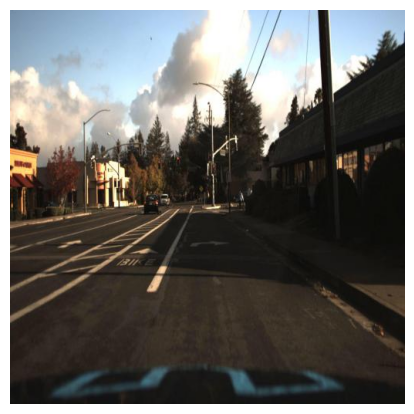

In [ ]:
# transforms
train_tfms = v2.Compose([
    #v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    #v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300)),                        # pick a fixed size for batching
    #v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

train_data.show_with_box(index=53, color='r', label=False, lw=0)

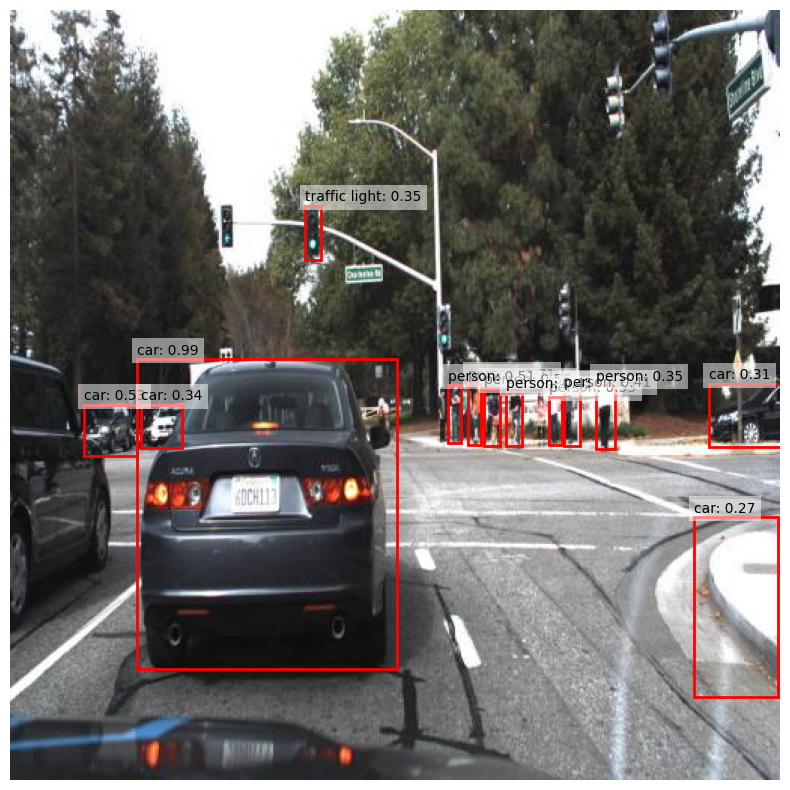

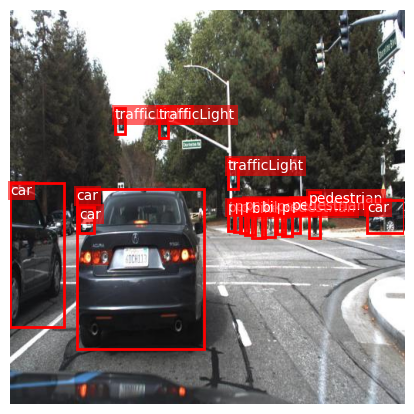

In [40]:
# 1) Device and weights
# device = torch.device("cpu")   # or "cuda" if available
weights = SSD300_VGG16_Weights.DEFAULT
categories = weights.meta["categories"]  # list of class names

# 2) Model
model = ssd300_vgg16(weights=weights).to(device).eval()

# 3) Load image
rand_idx = np.random.randint(0, len(test_data), size=1)[0]
img = test_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = model(batch)[0]                          # dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
names = [categories[i] for i in labels]

# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

test_data_clean.show_with_box(index=rand_idx, color='r', label=True)

In [165]:
# load model + COCO category names (order matches the model head)
weights = SSD300_VGG16_Weights.COCO_V1
categories = weights.meta["categories"]                      # list[str], length N
N = len(categories)

# rename rules and your final ids
rename = {"bicycle": "biker", "person": "pedestrian", "traffic light": "trafficLight"}
final_order = ["biker", "car", "pedestrian", "trafficLight", "truck"]
final_id = {n: i for i, n in enumerate(final_order)}

allowed_src = {"person", "bicycle", "car", "truck", "traffic light"}

model = ssd300_vgg16(weights=weights).eval().to(device)
preprocess = weights.transforms()

@torch.no_grad()
def predict_subset(imgs, score_thresh=0.05, topk=200, return_names=True):
    """
    Returns per-image dicts with:
      boxes:  float32 (N,4) xyxy
      scores: float32 (N,)
      labels: int64 in {0..4} using your mapping
      names:  renamed strings if return_names=True
    """
    outs = model(imgs)
    results = []

    for det in outs:
        boxes  = det["boxes"]
        scores = det["scores"]
        labels = det["labels"]  # DO NOT assume base

        # threshold
        keep = scores >= score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        if labels.numel() == 0:
            results.append({
                "boxes":  boxes.to(torch.float32),
                "scores": scores.to(torch.float32),
                "labels": labels.new_zeros((0,), dtype=torch.int64),
                **({"names": []} if return_names else {})
            })
            continue

        # --- Detect label base (0-based vs 1-based) safely ---
        lmin, lmax = int(labels.min()), int(labels.max())
        if lmin < 0:
            raise ValueError(f"Negative label id {lmin} is invalid.")
        is_zero_based = (lmin == 0)
        if is_zero_based and lmax >= N:
            raise ValueError(f"Label max {lmax} out of range for {N} categories.")
        if (not is_zero_based) and (lmax > N):
            raise ValueError(f"1-based label max {lmax} out of range for {N} categories.")

        # map labels -> source names without off-by-one
        if is_zero_based:
            src_names = [categories[int(l)]     for l in labels]
        else:
            src_names = [categories[int(l) - 1] for l in labels]

        # keep only allowed classes by NAME (no id assumptions)
        keep_allowed = torch.tensor([n in allowed_src for n in src_names],
                                    device=labels.device, dtype=torch.bool)
        boxes, scores = boxes[keep_allowed], scores[keep_allowed]
        src_names = [n for n, m in zip(src_names, keep_allowed.tolist()) if m]

        if len(src_names) == 0:
            results.append({
                "boxes":  boxes.to(torch.float32),
                "scores": scores.to(torch.float32),
                "labels": torch.empty(0, device=labels.device, dtype=torch.int64),
                **({"names": []} if return_names else {})
            })
            continue

        # rename and map to your final contiguous ids
        renamed = [rename.get(n, n) for n in src_names]
        try:
            mapped_ids = torch.tensor([final_id[n] for n in renamed],
                                      device=labels.device, dtype=torch.int64)
        except KeyError as e:
            raise KeyError(f"Unexpected class after rename: {e.args[0]}") from e

        # top-k after filtering
        if scores.numel() > topk:
            idx = torch.topk(scores, topk).indices
            boxes  = boxes[idx]
            scores = scores[idx]
            mapped_ids = mapped_ids[idx]
            if return_names:
                renamed = [renamed[int(i)] for i in idx]

        out = {
            "boxes":  boxes.to(torch.float32),
            "scores": scores.to(torch.float32),
            "labels": mapped_ids,               # 0..4 exactly as requested
        }
        if return_names:
            out["names"] = renamed
        results.append(out)

    return results

In [ ]:
preprocess = weights.transforms()
imgs = [preprocess(your_image_tensor.to(device))]  # list of images

preds = predict_subset(imgs, score_thresh=0.25, return_names=True, remap_subset=True)

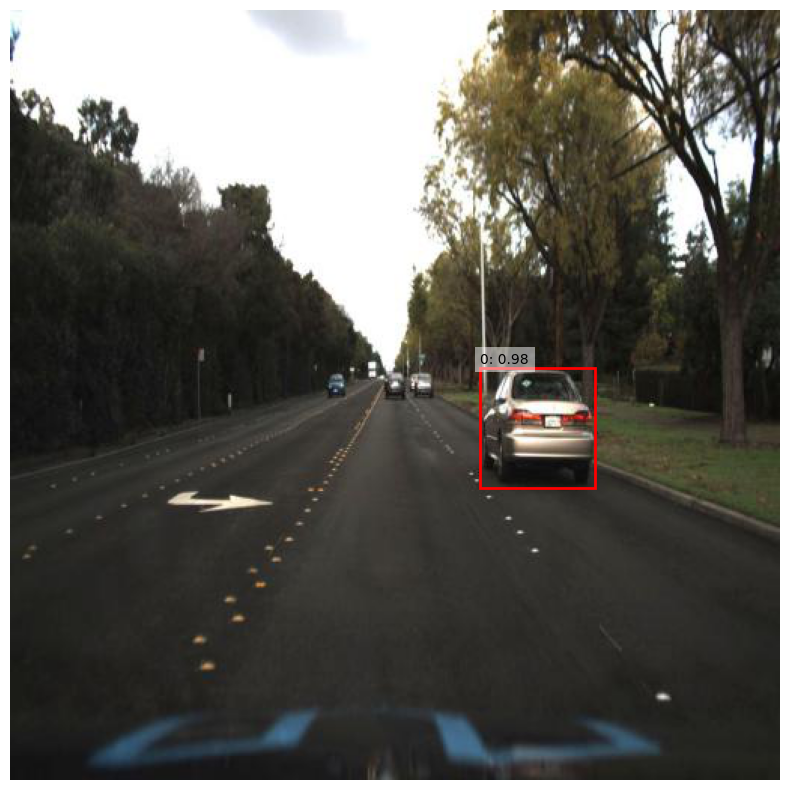

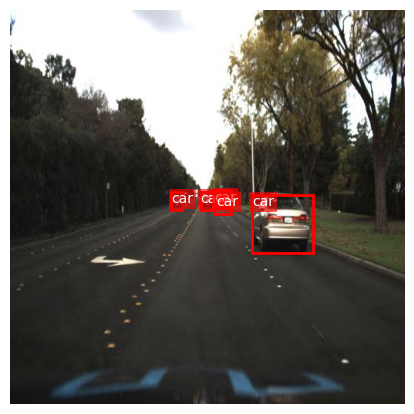

In [167]:
# 3) Load image
rand_idx = np.random.randint(0, len(test_data), size=1)[0]
img = test_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = predict_subset(batch, score_thresh=0.25, return_names=True)[0] # list of dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
newcategories = ["biker", "car", "pedestrian", "trafficLight", "truck"]
names = labels


# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

test_data_clean.show_with_box(index=rand_idx, color='r', label=True)

In [168]:
out

{'boxes': tensor([[312.2518, 237.7174, 388.7055, 317.5104]], device='cuda:0'),
 'scores': tensor([0.9797], device='cuda:0'),
 'labels': tensor([0], device='cuda:0'),
 'names': ['biker']}

In [64]:
test_data_clean[rand_idx][1]

{'image_id': tensor([4493]),
 'labels': tensor([1, 3, 3, 1, 3]),
 'boxes': BoundingBoxes([[ 17., 228., 215., 444.],
                [109., 119., 121., 159.],
                [173., 105., 185., 148.],
                [192., 230., 251., 304.],
                [276., 180., 286., 212.]], format=BoundingBoxFormat.XYXY, canvas_size=(512, 512)),
 'areas': tensor([42768.,   480.,   516.,  4366.,   320.]),
 'iscrowd': tensor([0, 0, 0, 0, 0])}